## Time series - Demand - Forecasting
https://www.kaggle.com/c/demand-forecasting-kernels-only

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import plotly.express as px
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
%matplotlib inline

In [3]:
#Set data path
time_series_train_path = Path('../data/time_series_train.csv')
time_series_test_path = Path('../data/time_series_test.csv')

In [4]:
#Load dataframe
train_df = pd.read_csv(time_series_train_path, parse_dates=['date'])
test_df = pd.read_csv(time_series_test_path, parse_dates=['date'], index_col=['id'])

In [5]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
test_df.head()

,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


## Data pre-processing

In [18]:
#Function to extract rolling average and take difference in attempt to create stationary time series
def sales_transform(dataf):
    
    new_df = (dataf
              .assign(sales_diff = dataf['sales'].diff(1)
                     )
             )
    
    return new_df

#Function to group dataframe by date
def group_date(dataf):
    
    grouped_df =  (dataf
                    .groupby('date')
                    .sum()
                    .reset_index()
                  )
    
    return grouped_df

In [19]:
#Create final train and test df
train_df_final = (train_df
                      .pipe(sales_transform)
                 )

In [20]:
train_df_final.head()

,date,store,item,sales,sales_diff
0,2013-01-01,1,1,13,NaN
1,2013-01-02,1,1,11,-2.0
2,2013-01-03,1,1,14,3.0
3,2013-01-04,1,1,13,-1.0
4,2013-01-05,1,1,10,-3.0


In [21]:
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        913000 non-null  datetime64[ns]
 1   store       913000 non-null  int64         
 2   item        913000 non-null  int64         
 3   sales       913000 non-null  int64         
 4   sales_diff  912999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 34.8 MB


In [22]:
#Create dataframe with sales grouped per date
train_df_final_group_date = (train_df
                                 .pipe(group_date)
                                 .pipe(sales_transform)
                            )

In [23]:
train_df_final_group_date.head()

,date,store,item,sales,sales_diff
0,2013-01-01,2750,12750,13696,NaN
1,2013-01-02,2750,12750,13678,-18.0
2,2013-01-03,2750,12750,14488,810.0
3,2013-01-04,2750,12750,15677,1189.0
4,2013-01-05,2750,12750,16237,560.0


## SARIMA (Seasonal ARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

### Trend elements

There are three trend elements that require configuration.
They are the same as the ARIMA model; specifically:

- p: Trend autoregression order: The number of lag observations included in the model, also called the lag order
- d: Trend difference order: The number of times that the raw observations are differenced, also called the degree of differencing
- q: Trend moving average order: The size of the moving average window, also called the order of moving average

### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

**Use non-stationary sales (differenced sales)**

In [64]:
y_diff = train_df_final_group_date['sales_diff'][1:]
X_diff = train_df_final_group_date['date'][1:]

In [56]:
sarimax_diff = sm.tsa.statespace.SARIMAX(y_diff, order=(0,1,1), seasonal_order=(0,1,1,7))

In [58]:
sarimax_diff_fitted = sarimax_model.fit()

In [59]:
y_diff_pred = (sarimax_diff_fitted
                  .get_prediction(start=0, dynamic=False)
                  .predicted_mean
              )

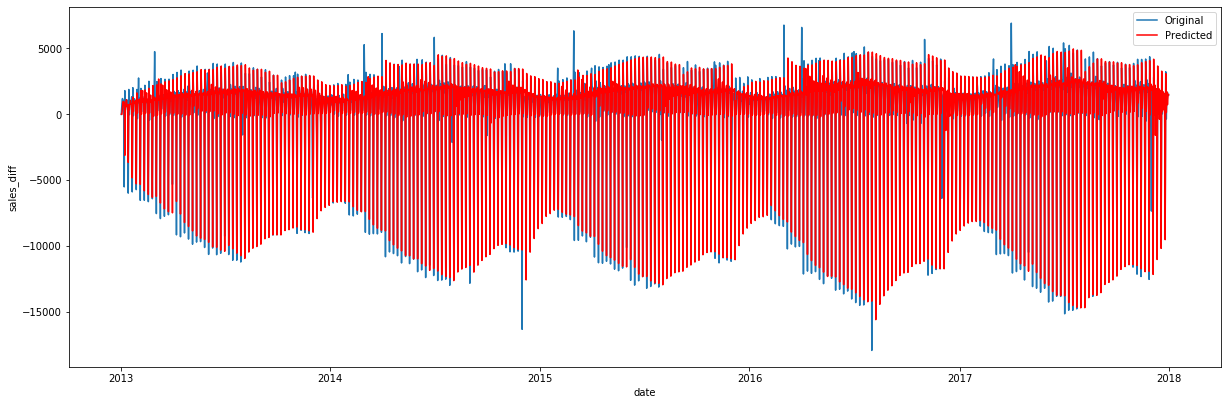

In [60]:
#Create object to plot on
fig = plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])

sns.lineplot(x=X_diff, y=y, ax=ax, label='Original')
sns.lineplot(x=X_diff, y=y_diff_pred, ax=ax, label='Predicted', color='red');

SMAPE = (1/n) * Σ(|forecast – actual| / (|actual| + |forecast|/2) * 100

where:

- Σ – a symbol that means “sum”
- n – sample size
- actual – the actual data value
- forecast – the forecasted data value

In [62]:
#Function to calculate SMAPE, a=actual, f=forecast
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [69]:
smape(y_diff, y_diff_pred)

36.89368310484431

**Use non-stationary sales (actual sales)**

In [65]:
y_actual = train_df_final_group_date['sales']
X_actual = train_df_final_group_date['date']

In [66]:
sarimax_actual = sm.tsa.statespace.SARIMAX(y_actual, order=(0,1,1), seasonal_order=(0,1,1,7))

In [67]:
sarimax_actual_fitted = sarimax_actual.fit()

In [68]:
y_actual_pred = (sarimax_actual_fitted
                      .get_prediction(start=0, dynamic=False)
                      .predicted_mean
                )

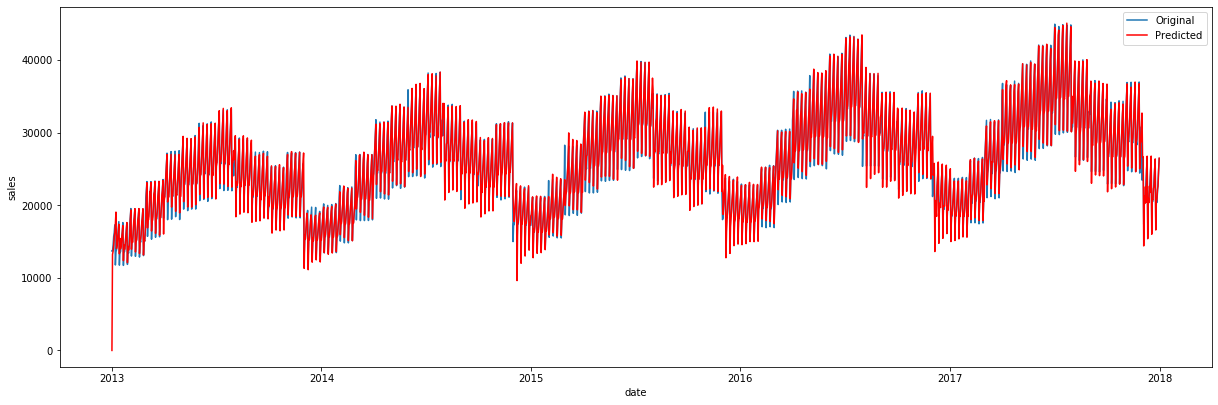

In [52]:
#Create object to plot on
fig = plt.figure(figsize=(16,5))
ax = fig.add_axes([0,0,1,1])

sns.lineplot(x=X_2, y=y_2, ax=ax, label='Original')
sns.lineplot(x=X_2, y=y_pred_2, ax=ax, label='Predicted', color='red');

In [70]:
smape(y_actual, y_actual_pred)

1.9604004686265142

**Use original data**

In [74]:
y = train_df_final['sales']
X = train_df_final['date']

In [76]:
sarimax_all = sm.tsa.statespace.SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,7))

In [77]:
sarimax_all_fitted = sarimax_all.fit()

MemoryError: Unable to allocate 1.97 GiB for an array with shape (913001, 17, 17) and data type float64

## Prophet

The procedure makes use of a decomposable time series model with three main model components: trend, seasonality, and holidays.

y(t) = g(t) + s(t) + h(t) + e(t)


g(t)
- trend models non-periodic changes; linear or logistic

s(t)
- seasonality represents periodic changes; i.e. weekly, monthly, yearly

h(t)
- ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

The error term e(t) represents any idiosyncratic changes which are not accommodated by the model; later we will make the parametric assumption that e(t) is normally distributed.

In [ ]:
#Create dataframe for prophet model
prophet_df = train_df_final[['date', 'sales']]
#Set column names needed for prophet
#Column names for prophet compliance
prophet_df.columns = ['ds','y']

In [ ]:
prophet_df['ds']

In [ ]:
#Creat prophet object
prophet = Prophet()

In [ ]:
#Fit the model
prophet.fit(prophet_df)